In [1]:
#!pip3 install kagglehub
#!pip3 install torch torchvision torchaudio
#!pip3 install matplotlib

In [2]:
import kagglehub
import torch
import os
import torch
from networkx.algorithms.lowest_common_ancestors import tree_all_pairs_lowest_common_ancestor
from torch.utils.data import Dataset
from PIL import Image
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import math
import matplotlib.patches as patches
import numpy as np
import torchvision
from tqdm import tqdm


/Users/mahdi/Desktop/Deep-Learning/Project3/env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
#!pip install --upgrade certifi
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [4]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

In [5]:
dataset_path = kagglehub.dataset_download('weiming97/hrsc2016-ms-dataset')

In [6]:
dataset_path = "/Users/mahdi/.cache/kagglehub/datasets/weiming97/hrsc2016-ms-dataset/versions/1"

In [7]:
print(dataset_path)

/Users/mahdi/.cache/kagglehub/datasets/weiming97/hrsc2016-ms-dataset/versions/1


## Dataset Creation

In [8]:
class ShipDataset(Dataset):
    def __init__(self, images_dir, annotations_dir, image_set_file, transform=None):
        self.images_dir = images_dir
        self.annotations_dir = annotations_dir
        self.transform = transform
        with open(image_set_file, 'r') as f:
            self.image_ids = [line.strip() for line in f]

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        img_path = os.path.join(self.images_dir, f"{image_id}.bmp")
        ann_path = os.path.join(self.annotations_dir, f"{image_id}.xml")
        image = Image.open(img_path).convert("RGB")
        midpoint_boxes = []

        tree = ET.parse(ann_path)
        root = tree.getroot()
        for obj in root.findall('object'):
            robnd = obj.find('robndbox')
            if robnd is None:
                continue
            cx = float(robnd.find('cx').text)
            cy = float(robnd.find('cy').text)
            w = float(robnd.find('w').text)
            h = float(robnd.find('h').text)
            angle = float(robnd.find('angle').text)
            # compute midpoint offsets
            cos_a = np.cos(angle)
            sin_a = np.sin(angle)
            dx, dy = w/2, h/2
            corners = np.array([[-dx,-dy],[dx,-dy],[dx,dy],[-dx,dy]])
            rot = np.array([[cos_a,-sin_a],[sin_a,cos_a]])
            rot_corners = corners @ rot.T
            trans = rot_corners + np.array([cx,cy])
            # compute external bbox dims
            bnd = obj.find('bndbox')
            if bnd is None:
                continue
            w_h = float(bnd.find('xmax').text) - float(bnd.find('xmin').text)
            h_h = float(bnd.find('ymax').text) - float(bnd.find('ymin').text)
            top_mid = np.array([cx, cy - h_h/2])
            right_mid = np.array([cx + w_h/2, cy])
            v1, v2 = trans[0], trans[1]
            delta_alpha = v1[0] - top_mid[0]
            delta_beta  = v2[1] - right_mid[1]
            midpoint_boxes.append([cx, cy, w_h, h_h, delta_alpha, delta_beta])

        midpoint_boxes = torch.tensor(midpoint_boxes, dtype=torch.float32)
        target = {'midpoint_boxes': midpoint_boxes}
        if self.transform:
            image = self.transform(image)
        else:
            image = image
        return image, target

In [9]:

train_dataset = ShipDataset(
    images_dir=os.path.join(dataset_path,"AllImages"),
    annotations_dir=os.path.join(dataset_path,  "Annotations"),
    image_set_file=os.path.join(dataset_path,  'ImageSets/Train.txt'),
    
)

In [10]:
train_dataset[0]

(<PIL.Image.Image image mode=RGB size=1144x820>,
 {'midpoint_boxes': tensor([[ 709.5618,  375.9656,  372.0000,  456.0000,  132.4550, -179.1230]])})

In [11]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

def plot_image_with_midpoints(image, target):
    fig, ax = plt.subplots(1)
    ax.imshow(np.array(image).astype(np.uint8))

    mid_boxes = target.get('midpoint_boxes')  # (x, y, w, h, Δα, Δβ)

    for i in range(len(mid_boxes)):
        
        x, y, w, h, delta_alpha, delta_beta = mid_boxes[i].tolist()

        v1 = (x + delta_alpha, y - h / 2) 
        v2 = (x + w / 2, y + delta_beta)    
        v3 = (x - delta_alpha, y + h / 2)   
        v4 = (x - w / 2, y - delta_beta)

        corners_mid = np.array([v1, v2, v3, v4])

        polygon_mid = patches.Polygon(corners_mid, closed=True,
                                      edgecolor='red', facecolor='none', linewidth=2)
        ax.add_patch(polygon_mid)

    plt.axis('off')
    plt.show()


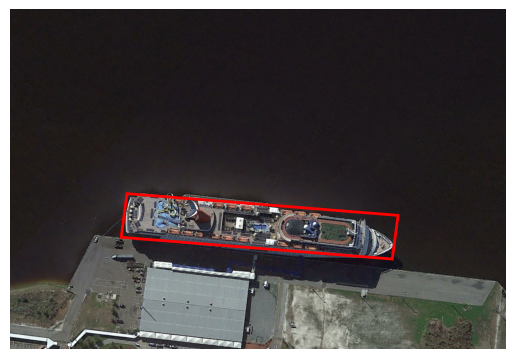

In [12]:
plot_image_with_midpoints(train_dataset[89][0], train_dataset[89][1])


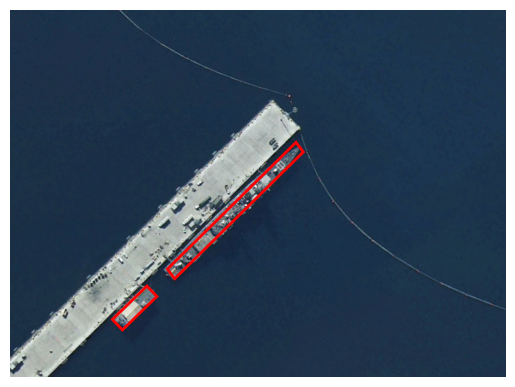

In [13]:
plot_image_with_midpoints(train_dataset[389][0], train_dataset[389][1])

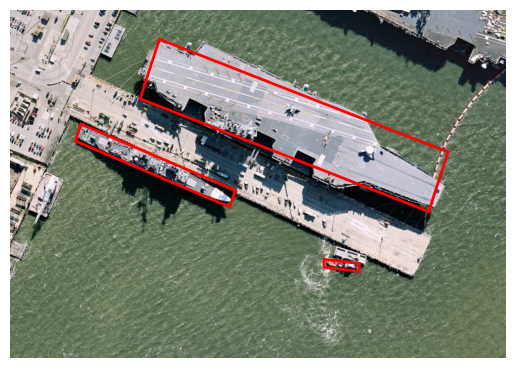

In [14]:
plot_image_with_midpoints(train_dataset[94][0], train_dataset[94][1])

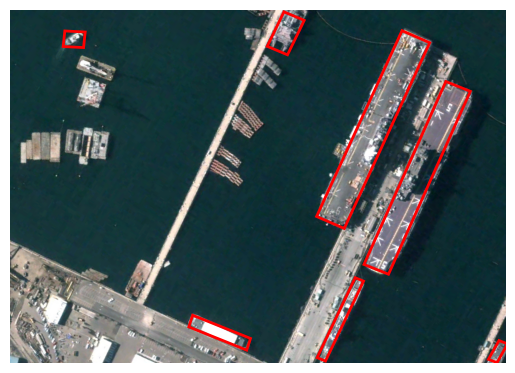

In [18]:
plot_image_with_midpoints(train_dataset[75][0], train_dataset[75][1])

In [ ]:
import torchvision
import torch.nn as nn

In [ ]:
backbone = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

In [ ]:
backbone

In [ ]:
backbone.backbone.fpn

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision.models import resnet50
from torchvision.ops import nms, box_iou
import numpy as np

class OrientedRPN(nn.Module):
    def __init__(self, in_channels=256, num_anchors=3):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, in_channels, 3, padding=1)
        self.cls_logits = nn.Conv2d(in_channels, num_anchors * 2, 1)
        self.bbox_pred = nn.Conv2d(in_channels, num_anchors * 6, 1)
        for l in [self.conv, self.cls_logits, self.bbox_pred]:
            nn.init.normal_(l.weight, std=0.01)
            nn.init.constant_(l.bias, 0)

    def forward(self, features):
        cls_scores, bbox_preds = [], []
        for x in features:
            t = F.relu(self.conv(x))
            cls_scores.append(self.cls_logits(t))
            bbox_preds.append(self.bbox_pred(t))
        return cls_scores, bbox_preds


In [ ]:
import torch
import torch.nn.functional as F

class RotatedRoIAlign(nn.Module):
    def __init__(self, output_size=(7,7), spatial_scale=1.0):
        super().__init__()
        self.output_size, self.spatial_scale = output_size, spatial_scale

    def forward(self, feature, rois):
        """
        Args:
            feature: Tensor of shape [C, H, W]
            rois: Tensor of shape [N, 5] (x, y, w, h, theta)
        Returns:
            output: Tensor of shape [N, C, H_out, W_out]
        """
        device = feature.device
        N, C = rois.size(0), feature.size(0)
        H_out, W_out = self.output_size
        output = torch.zeros(N, C, H_out, W_out, device=device)

        # Precompute feature dims
        H_feat, W_feat = feature.size(1), feature.size(2)
        for i in range(N):
            x, y, w, h, theta = rois[i]
            # Scale rois to feature resolution
            x_s = x * self.spatial_scale
            y_s = y * self.spatial_scale
            w_s = w * self.spatial_scale
            h_s = h * self.spatial_scale

            # Create sampling grid in local box coords
            grid_y = torch.linspace(-0.5, 0.5, H_out, device=device)
            grid_x = torch.linspace(-0.5, 0.5, W_out, device=device)
            grid_y, grid_x = torch.meshgrid(grid_y, grid_x, indexing='ij')
            grid = torch.stack([grid_x * w_s, grid_y * h_s], dim=-1)

            # Rotation
            cos_t, sin_t = torch.cos(theta), torch.sin(theta)
            R = torch.tensor([[cos_t, -sin_t], [sin_t, cos_t]], device=device)
            grid_rot = grid @ R

            # Translate to feature coords
            coords = grid_rot + torch.tensor([x_s, y_s], device=device)

            # Normalize coords to [-1,1]
            coords_norm = coords.clone()
            coords_norm[..., 0] = coords_norm[..., 0] / (W_feat - 1) * 2 - 1
            coords_norm[..., 1] = coords_norm[..., 1] / (H_feat - 1) * 2 - 1
            coords_norm = coords_norm.unsqueeze(0)

            feat = feature.unsqueeze(0)
            # MPS fallback
            if feat.device.type == 'mps':
                f_cpu = feat.cpu()
                g_cpu = coords_norm.cpu()
                sampled = F.grid_sample(f_cpu, g_cpu, align_corners=True)
                sampled = sampled.to(device)
            else:
                sampled = F.grid_sample(feat, coords_norm, align_corners=True)

            output[i] = sampled.squeeze(0)

        return output


In [ ]:
class AnchorGenerator:
    def __init__(self, scales=[32, 64, 128, 256, 512], ratios=[0.5, 1.0, 2.0], strides=[4, 8, 16, 32, 64]):
        self.scales = scales
        self.ratios = ratios
        self.strides = strides

    def generate(self, feature_shapes, device):
        anchors = []
        for scale, stride, (h, w) in zip(self.scales, self.strides, feature_shapes):
            areas = scale * scale
            sizes = [np.sqrt(areas / r) for r in self.ratios]
            ws = [s * np.sqrt(r) for s, r in zip(sizes, self.ratios)]
            hs = [s / np.sqrt(r) for s, r in zip(sizes, self.ratios)]
            x_centers = torch.arange(0, w, device=device) * stride + stride / 2
            y_centers = torch.arange(0, h, device=device) * stride + stride / 2
            x_centers, y_centers = torch.meshgrid(x_centers, y_centers, indexing='ij')
            x_centers = x_centers.flatten()
            y_centers = y_centers.flatten()
            for w, h in zip(ws, hs):
                anchor = torch.stack([
                    x_centers, y_centers,
                    torch.full_like(x_centers, w),
                    torch.full_like(y_centers, h)
                ], dim=-1)
                anchors.append(anchor)
        return torch.cat(anchors)

In [ ]:
class OrientedRCNNHead(nn.Module):
    def __init__(self, in_channels=256, num_classes=2):
        super().__init__()
        self.roi_align = RotatedRoIAlign(output_size=(7,7), spatial_scale=1.0)
        self.fc1  = nn.Linear(in_channels * 7 * 7, 1024)
        self.fc2  = nn.Linear(1024, 1024)
        self.cls_score   = nn.Linear(1024, num_classes)
        self.bbox_refine = nn.Linear(1024, num_classes * 6)

    def forward(self, features, proposals):
        # --- NEW: squeeze batch dim (only batch_size=1 supported!) ---
        # features: [N, C, H, W]
        if features.dim() == 4 and features.size(0) == 1:
            feature = features[0]      # now [C, H, W]
        elif features.dim() == 3:
            feature = features         # already [C, H, W]
        else:
            raise NotImplementedError("OrientedRCNNHead only supports batch_size=1")

        # --- rest unchanged ---
        x = self.roi_align(feature, proposals)  # now receives [C,H,W]
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        scores     = self.cls_score(x)
        bbox_deltas= self.bbox_refine(x)
        return scores, bbox_deltas


In [ ]:
class OrientedRCNN(nn.Module):
    def __init__(self, num_classes=2):
        super(OrientedRCNN, self).__init__()
        self.backbone = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
        self.backbone.body = self.backbone.backbone.body
        self.fpn = self.backbone.backbone.fpn
        self.fpn_out_channels = 256
        self.rpn = OrientedRPN(in_channels=self.fpn_out_channels)
        self.head = OrientedRCNNHead(num_classes=num_classes)
        self.anchor_generator = AnchorGenerator()

    def forward(self, images, targets=None):
        # Get features from backbone (returns OrderedDict)
        features = self.backbone.body(images)
        # Pass OrderedDict directly to FPN
        features = self.fpn(features)
        feature_shapes = [(f.size(2), f.size(3)) for f in features.values()]
        anchors = self.anchor_generator.generate(feature_shapes, device=images.device)
        cls_scores, bbox_preds = self.rpn(list(features.values()))
        
        proposals = []
        start = 0
        for cls, bbox in zip(cls_scores, bbox_preds):
            batch, _, h, w = cls.shape
            num_anchors = 3
            cls = cls.view(batch, num_anchors, 2, h, w).permute(0, 3, 4, 1, 2).reshape(batch, h * w * num_anchors, 2)
            bbox = bbox.view(batch, num_anchors, 6, h, w).permute(0, 3, 4, 1, 2).reshape(batch, h * w * num_anchors, 6)
            for b in range(batch):
                cls_b = cls[b].sigmoid()
                bbox_b = bbox[b]
                num_anchors_level = h * w * num_anchors
                anchors_level = anchors[start:start + num_anchors_level]
                start += num_anchors_level
                props = self.decode_proposals(anchors_level, bbox_b)
                scores = cls_b[:, 1]
                keep = nms(props[:, :4], scores, 0.8)[:2000]
                proposals.append(props[keep])
        proposals = torch.cat(proposals)

        cls_scores, bbox_deltas = self.head(features[list(features.keys())[0]], proposals)

        if self.training:
            rpn_loss = self.compute_rpn_loss(cls_scores, bbox_preds, anchors, targets)
            rcnn_loss = self.compute_rcnn_loss(cls_scores, bbox_deltas, proposals, targets)
            return {"rpn_loss": rpn_loss, "rcnn_loss": rcnn_loss}
        return proposals, cls_scores, bbox_deltas

    def decode_proposals(self, anchors, bbox_preds):
        x = anchors[:, 0] + bbox_preds[:, 0] * anchors[:, 2]
        y = anchors[:, 1] + bbox_preds[:, 1] * anchors[:, 3]
        w = anchors[:, 2] * torch.exp(bbox_preds[:, 2])
        h = anchors[:, 3] * torch.exp(bbox_preds[:, 3])
        delta_alpha = bbox_preds[:, 4] * anchors[:, 2]
        delta_beta = bbox_preds[:, 5] * anchors[:, 3]
        theta = torch.atan2(delta_beta, delta_alpha)
        return torch.stack([x, y, w, h, theta], dim=1)

    def compute_rpn_loss(self, cls_scores, bbox_preds, anchors, targets):
        batch_size = len(targets)
        rpn_cls_loss = 0
        rpn_reg_loss = 0

        for i in range(batch_size):
            gt_boxes = targets[i]
            gt_horizontal_boxes = torch.stack([
                gt_boxes[:, 0] - gt_boxes[:, 2] / 2,
                gt_boxes[:, 1] - gt_boxes[:, 3] / 2,
                gt_boxes[:, 0] + gt_boxes[:, 2] / 2,
                gt_boxes[:, 1] + gt_boxes[:, 3] / 2
            ], dim=1)
            anchors_xyxy = torch.stack([
                anchors[:, 0] - anchors[:, 2] / 2,
                anchors[:, 1] - anchors[:, 3] / 2,
                anchors[:, 0] + anchors[:, 2] / 2,
                anchors[:, 1] + anchors[:, 3] / 2
            ], dim=1)
            iou = box_iou(anchors_xyxy, gt_horizontal_boxes)
            max_iou, max_iou_idx = iou.max(dim=1)
            labels = torch.zeros(anchors.size(0), dtype=torch.long, device=device)
            labels[max_iou < 0.3] = 0
            labels[max_iou >= 0.7] = 1
            for j in range(gt_boxes.size(0)):
                gt_iou = iou[:, j]
                max_gt_iou, max_anchor_idx = gt_iou.max(dim=0)
                if max_gt_iou > 0.3:
                    labels[max_anchor_idx] = 1
            positive_idx = (labels == 1).nonzero(as_tuple=False).flatten()
            negative_idx = (labels == 0).nonzero(as_tuple=False).flatten()
            num_positive = min(len(positive_idx), 128)
            num_negative = 256 - num_positive if num_positive < 128 else 128
            pos_perm = torch.randperm(len(positive_idx), device=device)[:num_positive] if num_positive > 0 else torch.tensor([], dtype=torch.long, device=device)
            neg_perm = torch.randperm(len(negative_idx), device=device)[:num_negative] if num_negative > 0 else torch.tensor([], dtype=torch.long, device=device)
            sampled_idx = torch.cat([positive_idx[pos_perm], negative_idx[neg_perm]])
            cls_flat = torch.cat([cls[i].permute(1, 2, 0).reshape(-1, 2) for cls in cls_scores])
            bbox_flat = torch.cat([bbox[i].permute(1, 2, 0).reshape(-1, 6) for bbox in bbox_preds])
            cls_pred = cls_flat[sampled_idx]
            labels_sampled = labels[sampled_idx]
            cls_loss = F.cross_entropy(cls_pred, labels_sampled)
            pos_sampled_idx = sampled_idx[labels_sampled == 1]
            if len(pos_sampled_idx) > 0:
                assigned_gt_idx = max_iou_idx[pos_sampled_idx]
                gt_midpoint = gt_boxes[assigned_gt_idx]
                anchors_pos = anchors[pos_sampled_idx]
                t_x = (gt_midpoint[:, 0] - anchors_pos[:, 0]) / anchors_pos[:, 2]
                t_y = (gt_midpoint[:, 1] - anchors_pos[:, 1]) / anchors_pos[:, 3]
                t_w = torch.log(gt_midpoint[:, 2] / anchors_pos[:, 2])
                t_h = torch.log(gt_midpoint[:, 3] / anchors_pos[:, 3])
                t_alpha = gt_midpoint[:, 4] / anchors_pos[:, 2]
                t_beta = gt_midpoint[:, 5] / anchors_pos[:, 3]
                t_star = torch.stack([t_x, t_y, t_w, t_h, t_alpha, t_beta], dim=1)
                bbox_pred_pos = bbox_flat[pos_sampled_idx]
                reg_loss = F.smooth_l1_loss(bbox_pred_pos, t_star, reduction='sum') / len(pos_sampled_idx)
            else:
                reg_loss = torch.tensor(0.0, device=device)
            rpn_cls_loss += cls_loss
            rpn_reg_loss += reg_loss

        rpn_cls_loss /= batch_size
        rpn_reg_loss /= batch_size
        return rpn_cls_loss + rpn_reg_loss

    def compute_rcnn_loss(self, cls_scores, bbox_deltas, proposals, targets):
        return torch.tensor(0.0, device=cls_scores.device, requires_grad=True)

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
import torch
import torch.nn.functional as F
    # Custom collate to pad images and collect targets
def custom_collate(batch):
    images = [item[0] for item in batch]
    targets = [item[1] for item in batch]
    # Find max dims
    max_h = max(img.size(1) for img in images)
    max_w = max(img.size(2) for img in images)
    padded = []
    for img in images:
        pad_h = max_h - img.size(1)
        pad_w = max_w - img.size(2)
        padded.append(F.pad(img, (0, pad_w, 0, pad_h)))
    images = torch.stack(padded).to(device)
    return images, targets

In [ ]:

train_dataset = ShipDataset(
    images_dir=os.path.join(dataset_path,"AllImages"),
    annotations_dir=os.path.join(dataset_path,  "Annotations"),
    image_set_file=os.path.join(dataset_path,  'ImageSets/Train.txt'),
    transform=torchvision.transforms.ToTensor()
)



In [ ]:
def train_oriented_rcnn(model, 
                        train_dataset, 
                        device=None,
                        batch_size=1, 
                        epochs=10, 
                        learning_rate=0.002, 
                        weight_decay=1e-4, 
                        momentum=0.9):
    if device is None:
        device = torch.device('mps' if torch.mps.is_available() else 'cpu')

    dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=custom_collate)

    model.to(device)
    model.train()
    
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate,
                                momentum=momentum, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=int(0.7*epochs), gamma=0.1)

    for epoch in range(1, epochs + 1):
        running_loss = 0.0
        loop = tqdm(dataloader, desc=f"Epoch {epoch}/{epochs}")
        for images, targets in loop:
            images = images.to(device)
            # Move target tensors to device
            targets = [{k: v.to(device) for k, v in tgt.items()} for tgt in targets]
            
            losses = model(images, targets)
            loss = sum(losses.values())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            loop.set_postfix(loss=loss.item())

        scheduler.step()
        avg_loss = running_loss / len(dataloader)
        print(f"[Epoch {epoch}] Avg Loss: {avg_loss:.4f}")
    
    print("Training complete.")
    return model

In [ ]:

model = OrientedRCNN(num_classes=2).to(device)
trained_model = train_oriented_rcnn(model, train_dataset, device=device, epochs=12)


In [23]:

def plot_loss_for_training(train_loss_history, model_name):
    plt.figure(figsize=(12, 6))
    plt.title(f"{model_name}Training")

    plt.plot(train_loss_history, label='Train Loss', color='red')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss History')
    plt.legend()

    
    # Show the plot
    plt.tight_layout()
    plt.show()

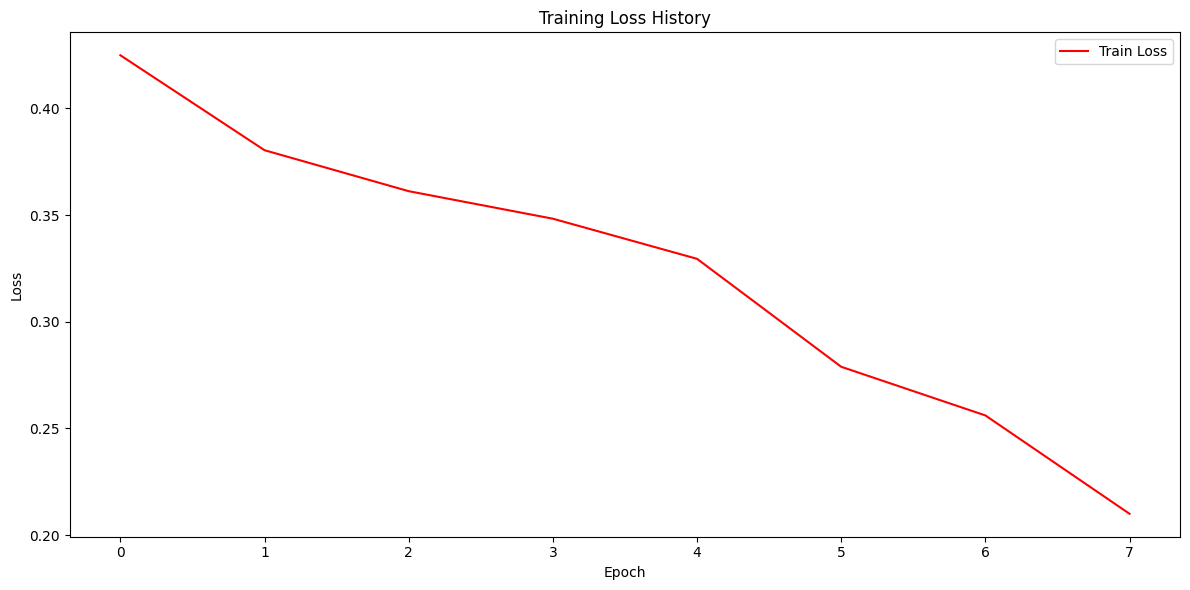

In [24]:
plot_loss_for_training(loss, "Oriented RCNN")